In [139]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, activations, losses, optimizers, metrics
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats

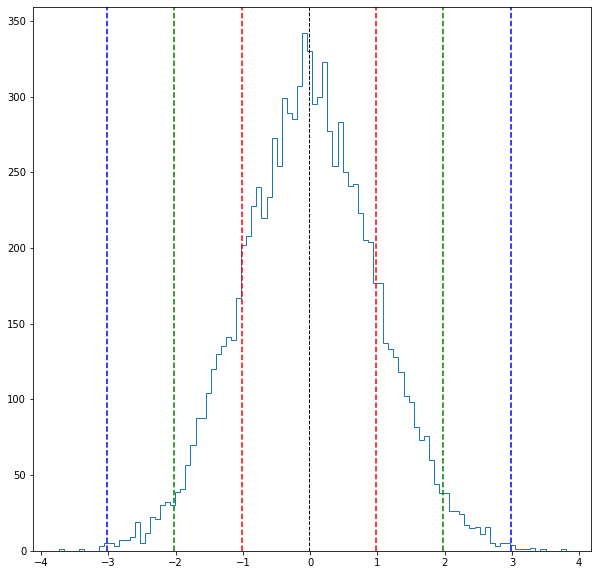

In [145]:
np.random.seed(0)
population = np.random.normal(loc=0, scale=1, size=10_000)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.hist(population, bins=100, histtype='step')

std = 1
mean = np.mean(population)

plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mean + std, color='r', linestyle='dashed')
plt.axvline(mean - std, color='r', linestyle='dashed')

plt.axvline(mean + std * 2, color='g', linestyle='dashed')
plt.axvline(mean - std * 2, color='g', linestyle='dashed')

plt.axvline(mean + std * 3, color='b', linestyle='dashed')
plt.axvline(mean - std * 3, color='b', linestyle='dashed')

In [117]:
train_df = pd.read_csv("dataset_train.csv")
val_df = pd.read_csv("dataset_val.csv")

In [118]:
train_df

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,state
0,-0.774121,-9.433371,1.784629,0.012470,-0.020279,0.001386,STAND
1,-0.759082,-9.441336,1.766234,0.001488,-0.017445,-0.002156,STAND
2,-0.726570,-9.446578,1.737082,-0.009375,-0.016630,-0.005044,STAND
3,-0.691625,-9.455801,1.717754,-0.010948,-0.015826,-0.009066,STAND
4,-0.647156,-9.461336,1.690160,-0.010913,-0.018142,-0.011370,STAND
...,...,...,...,...,...,...,...
17115,-0.369055,-9.602301,1.091332,0.004793,0.006843,0.002358,STAND
17116,-0.379781,-9.598336,1.106293,0.004885,0.004316,0.003684,STAND
17117,-0.388988,-9.594660,1.121250,0.006213,0.007398,0.003539,STAND
17118,-0.396617,-9.593133,1.142656,0.007079,0.007009,0.003251,STAND


In [119]:
def encode(df):
    df.state = df.state.astype('category')
    df.state = df.state.cat.codes
    return df


train_df = encode(train_df)
val_df = encode(val_df)

In [120]:
train_df

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,state
0,-0.774121,-9.433371,1.784629,0.012470,-0.020279,0.001386,8
1,-0.759082,-9.441336,1.766234,0.001488,-0.017445,-0.002156,8
2,-0.726570,-9.446578,1.737082,-0.009375,-0.016630,-0.005044,8
3,-0.691625,-9.455801,1.717754,-0.010948,-0.015826,-0.009066,8
4,-0.647156,-9.461336,1.690160,-0.010913,-0.018142,-0.011370,8
...,...,...,...,...,...,...,...
17115,-0.369055,-9.602301,1.091332,0.004793,0.006843,0.002358,8
17116,-0.379781,-9.598336,1.106293,0.004885,0.004316,0.003684,8
17117,-0.388988,-9.594660,1.121250,0.006213,0.007398,0.003539,8
17118,-0.396617,-9.593133,1.142656,0.007079,0.007009,0.003251,8


<BarContainer object of 16 artists>

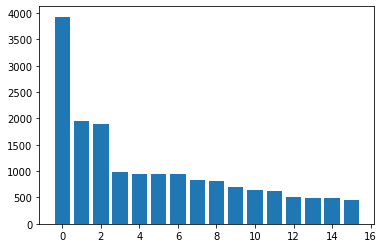

In [219]:
t = train_df.groupby('state').count()["accelerometer_x"].reset_index()
plt.bar(t['state'], t.sort_values(by='accelerometer_x', ascending=False)['accelerometer_x'])

Text(0.5, 1.0, 'Gyroscope Z')

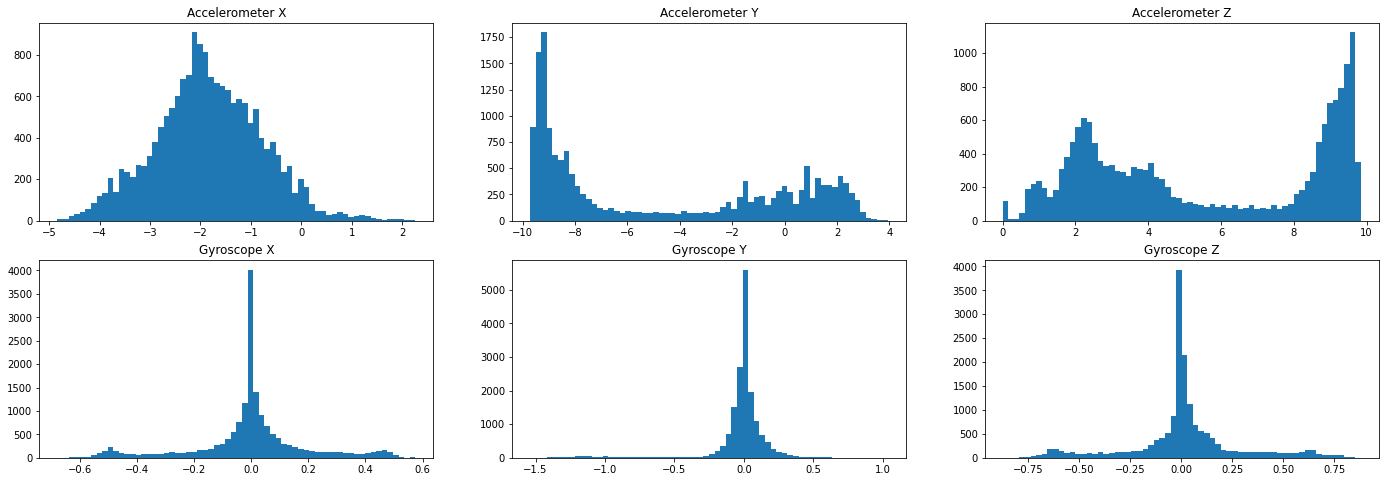

In [121]:
fig, ax = plt.subplots(2, 3, figsize=(8 * 3, 8))
ax[0, 0].hist(train_df.accelerometer_x, bins=64)
ax[0, 0].set_title("Accelerometer X")
ax[0, 1].hist(train_df.accelerometer_y, bins=64)
ax[0, 1].set_title("Accelerometer Y")
ax[0, 2].hist(train_df.accelerometer_z, bins=64)
ax[0, 2].set_title("Accelerometer Z")

ax[1, 0].hist(train_df.gyroscope_x, bins=64)
ax[1, 0].set_title("Gyroscope X")
ax[1, 1].hist(train_df.gyroscope_y, bins=64)
ax[1, 1].set_title("Gyroscope Y")
ax[1, 2].hist(train_df.gyroscope_z, bins=64)
ax[1, 2].set_title("Gyroscope Z")

In [122]:
def normalize(column):
    return (column - column.min()) / ((column.max() - column.min()) / 2) - 1


In [123]:
def normalize_columns(df):
    columns = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z']
    for column in columns:
        df[column] = normalize(df[column])
    return df


train_df = normalize_columns(train_df)
val_df = normalize_columns(val_df)


Text(0.5, 1.0, 'Gyroscope Z')

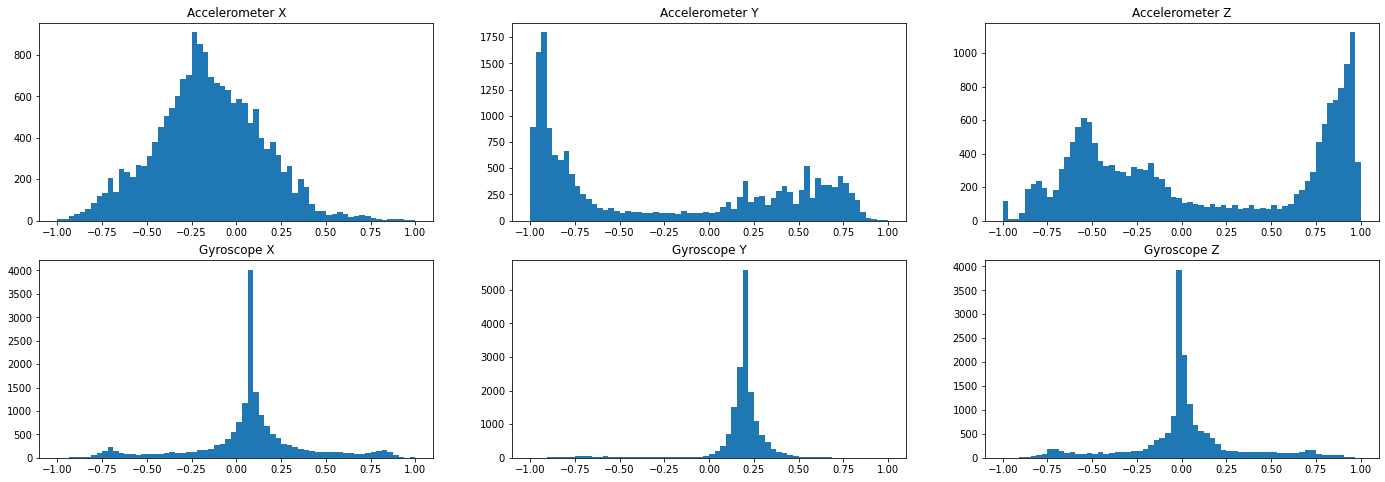

In [166]:
_, ax = plt.subplots(2, 3, figsize=(8 * 3, 8))

ax[0, 0].hist(train_df.accelerometer_x, bins=64)
ax[0, 0].set_title("Accelerometer X")
ax[0, 1].hist(train_df.accelerometer_y, bins=64)
ax[0, 1].set_title("Accelerometer Y")
ax[0, 2].hist(train_df.accelerometer_z, bins=64)
ax[0, 2].set_title("Accelerometer Z")

ax[1, 0].hist(train_df.gyroscope_x, bins=64)
ax[1, 0].set_title("Gyroscope X")
ax[1, 1].hist(train_df.gyroscope_y, bins=64)
ax[1, 1].set_title("Gyroscope Y")
ax[1, 2].hist(train_df.gyroscope_z, bins=64)
ax[1, 2].set_title("Gyroscope Z")

In [125]:
def create_window(df: pd.DataFrame, window=128, step=8):
    window_x = []
    window_y = []

    for i in range(0, len(df) - window, step):
        window_x.append(df.iloc[i:i + window])
        window_y.append(df.iloc[i + window]['state'])

    window_x = np.array(window_x)
    window_y = np.array(window_y)

    return window_x, window_y


train_x, train_y = create_window(train_df)
val_x, val_y = create_window(val_df)

In [126]:
_x = 128

fig = go.Figure()
fig.add_trace(go.Scatter(y=train_x[_x, :, 3]))
fig.add_trace(go.Scatter(y=train_x[_x, :, 4]))
fig.add_trace(go.Scatter(y=train_x[_x, :, 5]))

In [127]:
def shuffle_window(x, y):
    ind = np.arange(x.shape[0])
    np.random.shuffle(ind)
    return x[ind], y[ind]


train_x, train_y = shuffle_window(train_x, train_y)
val_x, val_y = shuffle_window(val_x, val_y)

In [128]:
def plot_history(title: str, history):
    _, ax = plt.subplots(1, 2, figsize=(6 * 3, 6))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.title(title)
    plt.legend()


# Hyper parameters

In [129]:
N_EPOCHS = 512
BATCH_SIZE = 128

Epoch 1/512
17/17 [==============================] - 4s 195ms/step - loss: 2.3907 - sparse_categorical_accuracy: 0.2759 - val_loss: 1.9673 - val_sparse_categorical_accuracy: 0.4316
Epoch 2/512
17/17 [==============================] - 3s 184ms/step - loss: 1.6667 - sparse_categorical_accuracy: 0.4816 - val_loss: 1.2765 - val_sparse_categorical_accuracy: 0.5973
Epoch 3/512
17/17 [==============================] - 3s 179ms/step - loss: 1.1205 - sparse_categorical_accuracy: 0.6281 - val_loss: 0.8934 - val_sparse_categorical_accuracy: 0.6859
Epoch 4/512
17/17 [==============================] - 3s 178ms/step - loss: 0.9100 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.8345 - val_sparse_categorical_accuracy: 0.6782
Epoch 5/512
17/17 [==============================] - 3s 176ms/step - loss: 0.8039 - sparse_categorical_accuracy: 0.7283 - val_loss: 0.7226 - val_sparse_categorical_accuracy: 0.7842
Epoch 6/512
17/17 [==============================] - 3s 190ms/step - loss: 0.7013 - sparse_cate

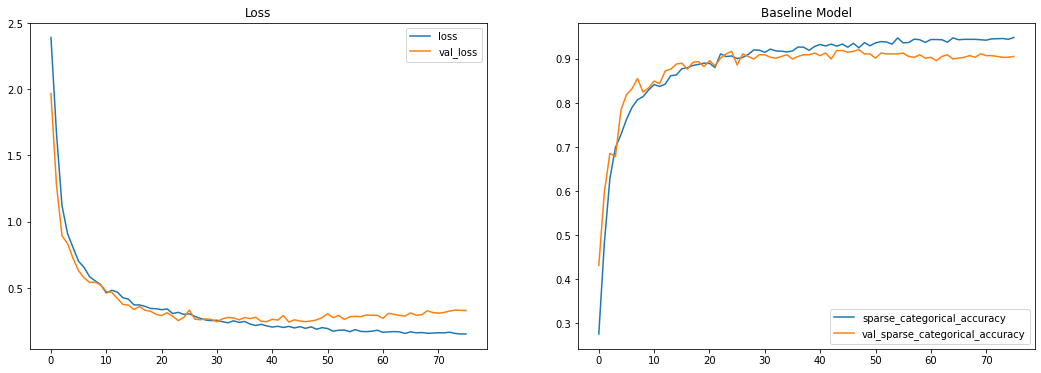

In [208]:
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=train_x.shape[0] // BATCH_SIZE,
    decay_rate=0.96,
    staircase=True)

import datetime

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)


def get_baseline_model(input_shape=(128, 7), n_output=16):
    model = models.Sequential()
    model.add(layers.LSTM(units=64, input_shape=input_shape))
    model.add(layers.Dense(units=128, activation=activations.relu))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(units=8, activation=activations.relu))
    model.add(layers.Dense(units=n_output, activation=activations.softmax))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate_schedule),
        loss=losses.sparse_categorical_crossentropy,
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


baseline_model = get_baseline_model()
baseline_model_history = baseline_model.fit(
    x=train_x, y=train_y,
    shuffle=True, validation_data=(val_x, val_y),
    epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping_callback])
plot_history('Baseline Model', baseline_model_history)

In [210]:
baseline_model.evaluate(x=val_x, y=val_y, batch_size=BATCH_SIZE)

5/5 [==============================] - 0s 63ms/step - loss: 0.2420 - sparse_categorical_accuracy: 0.9191


[0.2420186996459961, 0.9190751314163208]

Epoch 1/4
17/17 [==============================] - 1s 21ms/step - loss: 1.9470 - sparse_categorical_accuracy: 0.3941 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.6108
Epoch 2/4
17/17 [==============================] - 0s 15ms/step - loss: 1.1878 - sparse_categorical_accuracy: 0.5744 - val_loss: 0.9218 - val_sparse_categorical_accuracy: 0.6667
Epoch 3/4
17/17 [==============================] - 0s 16ms/step - loss: 0.9643 - sparse_categorical_accuracy: 0.6469 - val_loss: 0.7841 - val_sparse_categorical_accuracy: 0.6994
Epoch 4/4
17/17 [==============================] - 0s 15ms/step - loss: 0.8332 - sparse_categorical_accuracy: 0.7001 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.7264


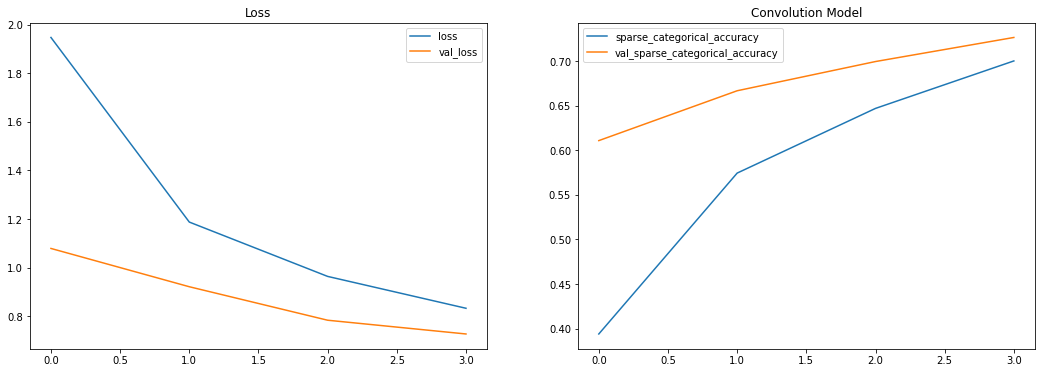

In [189]:
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.002,
    decay_steps=train_x.shape[0] // BATCH_SIZE,
    decay_rate=0.96,
    staircase=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)


def get_convolution_model(input_shape=(128, 7), n_output=16):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation=activations.relu, input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation=activations.relu))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation=activations.relu))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=n_output, activation=activations.softmax))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate_schedule),
        loss=losses.sparse_categorical_crossentropy,
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


convolution_model = get_convolution_model()
convolution_model_history = convolution_model.fit(
    x=train_x, y=train_y,
    shuffle=True, validation_data=(val_x, val_y),
    epochs=4, batch_size=BATCH_SIZE, callbacks=[early_stopping_callback])
plot_history('Convolution Model', convolution_model_history)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 128, 32)           5120      
                                                                 
 lstm_41 (LSTM)              (None, 128, 32)           8320      
                                                                 
 conv1d_55 (Conv1D)          (None, 62, 64)            10304     
                                                                 
 max_pooling1d_45 (MaxPoolin  (None, 31, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_56 (Conv1D)          (None, 29, 128)           24704     
                                                                 
 flatten_18 (Flatten)        (None, 3712)              0         
                                                     

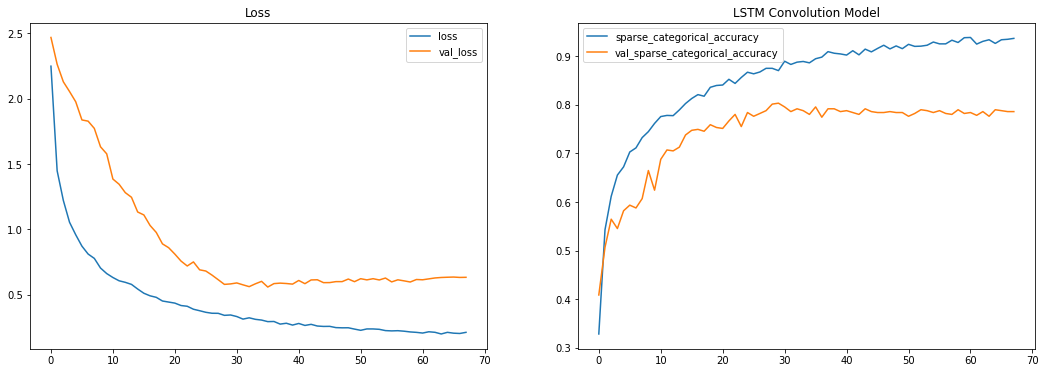

In [133]:
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=train_x.shape[0] // BATCH_SIZE,
    decay_rate=0.96,
    staircase=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)


def get_lstm_convolution_model(input_shape=(128, 7), n_output=16):
    model = models.Sequential()
    model.add(layers.LSTM(units=32, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(units=32, return_sequences=True))

    model.add(layers.Conv1D(filters=64, kernel_size=5, strides=2, activation=activations.relu))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation=activations.relu))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=64, activation=activations.relu))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units=n_output, activation=activations.softmax))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate_schedule),
        loss=losses.sparse_categorical_crossentropy,
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


lstm_convolution_model = get_lstm_convolution_model()

lstm_convolution_model.summary()

lstm_convolution_model_history = lstm_convolution_model.fit(
    x=train_x, y=train_y,
    shuffle=True, validation_data=(val_x, val_y),
    epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping_callback])
plot_history('LSTM Convolution Model', lstm_convolution_model_history)

In [167]:
def get_bidirectional_lstm_model(input_shape=(128, 7), n_output=16):
    model = models.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(units=128, input_shape=input_shape)))
    model.add(layers.Dense(units=n_output, activation=activations.softmax))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=losses.sparse_categorical_crossentropy,
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


bidirectional_lstm_model = get_bidirectional_lstm_model()
bidirectional_lstm_model_history = bidirectional_lstm_model.fit(
    x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=N_EPOCHS, batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback])
plot_history('Bidirectional LSTM Model', bidirectional_lstm_model_history)

Epoch 1/512
17/17 [==============================] - 10s 441ms/step - loss: 2.3684 - sparse_categorical_accuracy: 0.2759 - val_loss: 2.0104 - val_sparse_categorical_accuracy: 0.3333
Epoch 2/512
17/17 [==============================] - 7s 427ms/step - loss: 1.6899 - sparse_categorical_accuracy: 0.4477 - val_loss: 1.4573 - val_sparse_categorical_accuracy: 0.5048
Epoch 3/512
17/17 [==============================] - 7s 434ms/step - loss: 1.2301 - sparse_categorical_accuracy: 0.5956 - val_loss: 1.0294 - val_sparse_categorical_accuracy: 0.6628
Epoch 4/512
17/17 [==============================] - 8s 446ms/step - loss: 0.9170 - sparse_categorical_accuracy: 0.7057 - val_loss: 0.7943 - val_sparse_categorical_accuracy: 0.7572
Epoch 5/512
17/17 [==============================] - 8s 453ms/step - loss: 0.7357 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.6554 - val_sparse_categorical_accuracy: 0.7958
Epoch 6/512
17/17 [==============================] - 8s 447ms/step - loss: 0.6331 - sparse_cat

KeyboardInterrupt: 

In [ ]:
def get_stacked_bidirectional_lstm_model(input_shape=(128, 7), n_output=16):
    model = models.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(units=128, return_sequences=True, input_shape=input_shape)))
    model.add(layers.Bidirectional(layers.LSTM(units=32)))
    model.add(layers.Dense(units=n_output, activation=activations.softmax))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=losses.sparse_categorical_crossentropy,
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


stacked_bidirectional_lstm_model = get_stacked_bidirectional_lstm_model()
stacked_bidirectional_lstm_model_history = stacked_bidirectional_lstm_model.fit(
    x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=32, callbacks=[early_stopping_callback])
plot_history('Stacked Bidirectional LSTM Model', stacked_bidirectional_lstm_model_history)